In [ ]:
#!pip install qulacs
#!pip install qulacsvis
#!pip install matplotlib
#!pip install numpy
#!pip install scipy
#!pip install tqdm

In [1]:
from qulacs import Observable, QuantumState, QuantumCircuit
from qulacsvis import circuit_drawer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# パラメータシフト法による勾配最適化

パラメータシフト法によって勾配を求めて、変分量子アルゴリズムの最適化をしてみます。ここでは前回と同様にハイゼンベルグ模型
$$H = \sum_{i} J_{i} (X_iX_{i+1} + Y_iY_{1+1} + Z_iZ_{i+1})$$
に対する VQE を行います。

まずハミルトニアンと適当なパラメータ付き量子回路を定義します。

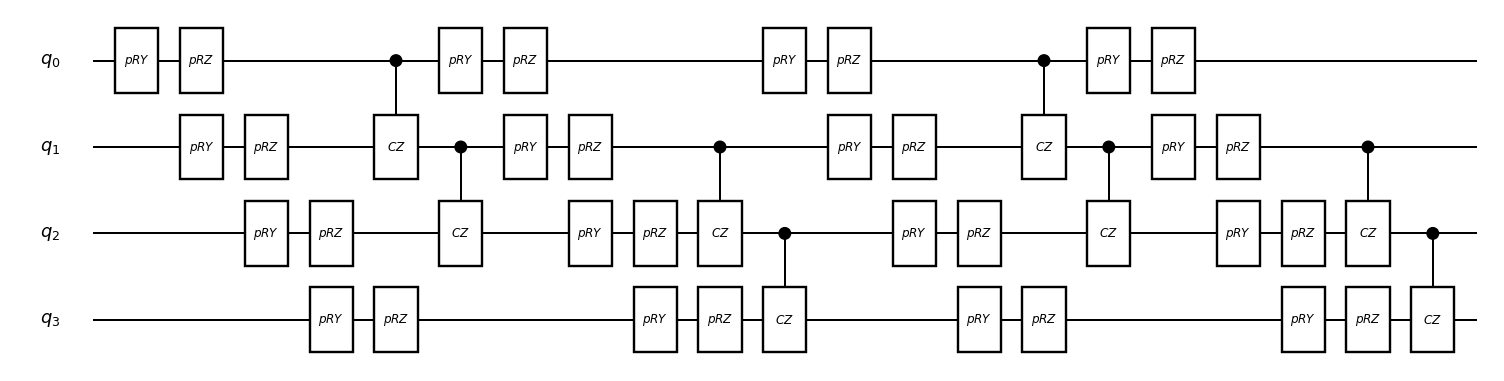

In [2]:
from qulacs import ParametricQuantumCircuit

n_qubits = 4
depth = 4
circuit = ParametricQuantumCircuit(n_qubits)
for d in range(depth):
    for i in range(n_qubits):
        circuit.add_parametric_RY_gate(i, 0.0)
        circuit.add_parametric_RZ_gate(i, 0.0)
    for i in range(n_qubits//2):
        circuit.add_CZ_gate((i+d%2)%n_qubits, (i+1+d%2)%n_qubits)

hamiltonian = Observable(n_qubits)
np.random.seed(1)
J_list = 2*np.random.rand(n_qubits)-1
for i in range(n_qubits):
    hamiltonian.add_operator(J_list[i], f"X {i} X {(i+1)%n_qubits}")
    hamiltonian.add_operator(J_list[i], f"Y {i} Y {(i+1)%n_qubits}")
    hamiltonian.add_operator(J_list[i], f"Z {i} Z {(i+1)%n_qubits}")
    
circuit_drawer(circuit, "mpl")

道具として、与えられたパラメータにおけるコスト関数 (この場合はエネルギー期待値) を返す関数を作っておきます。

In [3]:
def get_cost(params):
    state = QuantumState(n_qubits)
    for i, p in enumerate(params):
        circuit.set_parameter(i,p)
    circuit.update_quantum_state(state)
    return hamiltonian.get_expectation_value(state)

## パラメータシフト法による勾配
復習：$\langle H(\theta) \rangle = \langle \psi(\theta) | H | \psi(\theta) \rangle$ で、パラメータ $\theta$ がすべて $\exp(-i\theta P/2)$ ($P$はパウリ行列) の形で入っているとき、$\frac{\partial \langle H(\theta)\rangle}{\partial \theta_i}$ は次のように求まります。
$$\frac{\partial \langle H(\theta)\rangle}{\partial \theta_i} = \frac{1}{2}\left(\left\langle H\left(\theta+\frac{\pi}{2}e_i\right)\right)-\left\langle H\left(\theta-\frac{\pi}{2}e_i\right)\right\rangle\right)$$
ここで $e_i$ は $i$ 番目の成分だけ 1 でそれ以外はゼロのベクトルです。

In [4]:
# パラメータシフト法によって、あるパラメータ params における勾配ベクトルを求めるコードを書いてください。
def get_gradient_by_parameter_shift(params):
    grad_vector = np.zeros_like(params)
    tmp_params = np.copy(params)
    for i in range(len(params)):
        tmp_params[i] += np.pi/2
        plus = get_cost(tmp_params)
        tmp_params[i] -= np.pi
        minus = get_cost(tmp_params)
        grad_vector[i] = (plus-minus)/2
        tmp_params[i] = params[i]
    return grad_vector

正しく書けているか、有限差分による微分の近似値と比較しましょう。

In [5]:
def get_gradient_by_finite_diff(params, eps=1e-6):
    grad_vector = np.zeros_like(params)
    tmp_params = np.copy(params)
    for i in range(len(params)):
        tmp_params[i] += eps
        plus = get_cost(tmp_params)
        tmp_params[i] -= 2*eps
        minus = get_cost(tmp_params)
        grad_vector[i] = (plus-minus)/2/eps
        tmp_params[i] = params[i]
    return grad_vector

In [6]:
params = (2*np.random.random(circuit.get_parameter_count())-1)*np.pi
print(get_gradient_by_parameter_shift(params))
print(get_gradient_by_finite_diff(params))

[ 0.28641755 -0.00438154 -0.06712645 -0.32537361 -0.05751078  0.16557163
  0.11887725  0.10954547 -0.17033146 -0.24962483  0.12171529  0.35254303
 -0.39434455  0.16599231  0.2278707  -0.09372357  0.17685758  0.0195437
  0.02588595 -0.06820095  0.14981395 -0.43356911  0.27244975  0.25668482
  0.16067643 -0.02018968  0.70788171 -0.22227356 -0.03951543  0.43888274
 -0.20362175 -0.19641951]
[ 0.28641755 -0.00438154 -0.06712645 -0.32537361 -0.05751078  0.16557163
  0.11887725  0.10954547 -0.17033147 -0.24962483  0.12171529  0.35254303
 -0.39434455  0.16599231  0.2278707  -0.09372357  0.17685758  0.0195437
  0.02588595 -0.06820095  0.14981395 -0.43356911  0.27244975  0.25668482
  0.16067643 -0.02018968  0.70788171 -0.22227356 -0.03951543  0.43888274
 -0.20362175 -0.19641951]


## 最適化
勾配降下法によって最適化しますが、先に答えを知っておきたいので、基底状態のエネルギーを得ておきましょう

In [7]:
from utility import get_matrix
from scipy.sparse.linalg import eigsh
eigvals = eigsh(get_matrix(hamiltonian), which="SR")[0]
print("ground state energy is:", min(eigvals))

ground state energy is: -2.2830906123847066


単純な勾配降下法によって最適化を行います。

In [8]:
n_steps = 1000
rate = 0.1
params = (2*np.random.random(circuit.get_parameter_count())-1)*np.pi
cost_history = np.zeros(n_steps)
for i in tqdm(range(n_steps)):
    params -= get_gradient_by_parameter_shift(params)*rate
    cost_history[i] = get_cost(params)

100%|██████████| 1000/1000 [01:33<00:00, 10.64it/s]


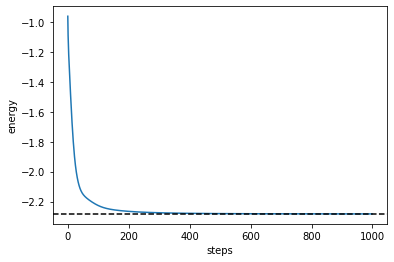

In [9]:
plt.plot(cost_history)
plt.axhline(min(eigvals), color="black", linestyle="dashed")
plt.ylabel("energy")
plt.xlabel("steps")
plt.show()

最適化できていますね。

## 発展編：統計ノイズのもとでの勾配降下法

前回行ったように、実際の実験では必ずサンプリングに伴う統計ノイズが発生します。統計ノイズのもとでも勾配降下法が機能するか見てみましょう。

まずは統計ノイズを含むコスト関数を定義します。前回のサンプリングコードを流用します。

In [10]:
def sample_ZZ(state, _n_shots):
    global J_list
    samples = state.sampling(_n_shots)
    estimated_energy = 0
    mask_list = [0b0011, 0b0110, 0b1100, 0b1001]
    for s in samples:
        for J, mask in zip(J_list, mask_list):
            bitcount = bin(s & mask).count("1")
            estimated_energy += J*(-1)**bitcount/_n_shots
    return estimated_energy

from qulacs.gate import H, Sdag
def sample_XX(state, _n_shots):
    global J_list
    for i in range(n_qubits):
        H(i).update_quantum_state(state)
    samples = state.sampling(_n_shots)
    estimated_energy = 0
    mask_list = [0b0011, 0b0110, 0b1100, 0b1001]
    for s in samples:
        for J, mask in zip(J_list, mask_list):
            bitcount = bin(s & mask).count("1")
            estimated_energy += J*(-1)**bitcount/_n_shots
    return estimated_energy

def sample_YY(state, _n_shots):
    global J_list
    for i in range(n_qubits):
        Sdag(i).update_quantum_state(state)
        H(i).update_quantum_state(state)
    samples = state.sampling(_n_shots)
    estimated_energy = 0
    mask_list = [0b0011, 0b0110, 0b1100, 0b1001]
    for s in samples:
        for J, mask in zip(J_list, mask_list):
            bitcount = bin(s & mask).count("1")
            estimated_energy += J*(-1)**bitcount/_n_shots
    return estimated_energy

def sample_cost(params, n_shots=1000):
    state = QuantumState(n_qubits)
    for i, p in enumerate(params):
        circuit.set_parameter(i,p)
    circuit.update_quantum_state(state)
    return sample_ZZ(state, n_shots) + sample_XX(state, n_shots) + sample_YY(state, n_shots)

一応正しくサンプリングできていることを確認しておきます。

100%|██████████| 1000/1000 [00:12<00:00, 79.96it/s]


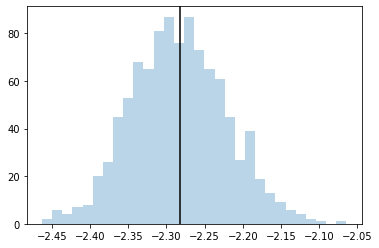

In [11]:
n_tests = 1000
costs = np.zeros(n_tests)
for i in tqdm(range(n_tests)):
    costs[i] = sample_cost(params)
plt.hist(costs, bins=30, alpha=0.3)
plt.axvline(get_cost(params), color="black")
plt.show()

できているようなので、最適化に移ります。

### 有限差分による最適化
まずは有限差分で最適化してみましょう。サンプリングをすると少し時間がかかるので、100 step だけやります。

In [12]:
def sample_gradient_by_finite_diff(params, eps=1e-6):
    grad_vector = np.zeros_like(params)
    tmp_params = np.copy(params)
    for i in range(len(params)):
        tmp_params[i] += eps
        plus = sample_cost(tmp_params)
        tmp_params[i] -= 2*eps
        minus = sample_cost(tmp_params)
        grad_vector[i] = (plus-minus)/2/eps
        tmp_params[i] = params[i]
    return grad_vector
n_steps = 100
rate = 0.1
np.random.seed(1)
params = (2*np.random.random(circuit.get_parameter_count())-1)*np.pi
cost_history_fd = np.zeros(n_steps)
for i in tqdm(range(n_steps)):
    params -= sample_gradient_by_finite_diff(params)*rate
    cost_history_fd[i] = get_cost(params)

100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


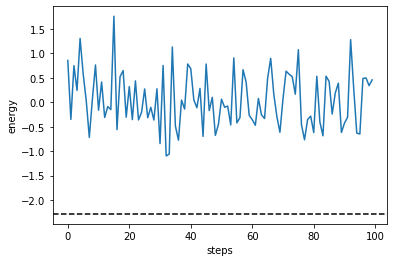

In [13]:
plt.plot(cost_history_fd)
plt.axhline(min(eigvals), color="black", linestyle="dashed")
plt.ylabel("energy")
plt.xlabel("steps")
plt.show()

全然最適化できていないことがわかります。これは $\langle H(\theta+\epsilon) \rangle$ と $\langle H(\theta) \rangle$ の差が統計誤差に負けているためだと考えられます。

### パラメータシフト法による最適化
次にパラメータシフト法によって最適化してみましょう。

In [14]:
def sample_gradient_by_parameter_shift(params, n_shots=1000):
    grad_vector = np.zeros_like(params)
    tmp_params = np.copy(params)
    for i in range(len(params)):
        tmp_params[i] += np.pi/2
        plus = sample_cost(tmp_params, n_shots)
        tmp_params[i] -= np.pi
        minus = sample_cost(tmp_params,n_shots)
        grad_vector[i] = (plus-minus)/2
        tmp_params[i] = params[i]
    return grad_vector
n_steps = 100
n_shots = 1000
rate = 0.1
np.random.seed(1)
params = (2*np.random.random(circuit.get_parameter_count())-1)*np.pi
cost_history_ps = np.zeros(n_steps)
for i in tqdm(range(n_steps)):
    params -= sample_gradient_by_parameter_shift(params, n_shots)*rate
    cost_history_ps[i] = get_cost(params)

100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


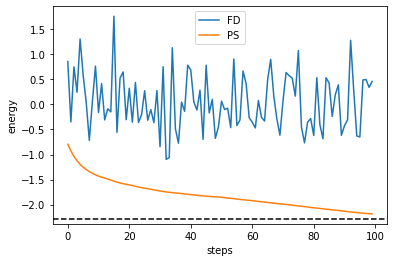

In [15]:
plt.plot(cost_history_fd, label="FD")
plt.plot(cost_history_ps, label="PS")
plt.axhline(min(eigvals), color="black", linestyle="dashed")
plt.ylabel("energy")
plt.xlabel("steps")
plt.legend()
plt.show()

パラメータシフト法が統計ノイズに対して圧倒的にロバストであることが確認できます。

### 確率的勾配降下法との関係
コスト関数 $f(\theta)$ について、$\mathbb{E}[\hat{g}(\theta)] = \nabla f(\theta)$ となるような乱数 $\hat{g}$ を使って、
$$\theta \to \theta - \alpha \hat{g}$$
と更新することによって最適化する方法を一般に確率的勾配降下法といいます。統計誤差付きのパラメータシフト法もこれと同じことをしているとみなせます。確率的勾配降下法では、$\hat{g}$ が $\nabla f$ の不偏推定量になっていさえいれば良いので、原理的には `n_shots` をどれだけ減らしてもパラメータシフト法は動くはずです。試しに `n_shots=1` でやってみましょう。

In [16]:
n_steps = 10000
n_shots = 1
rate = 0.1
np.random.seed(1)
params = (2*np.random.random(circuit.get_parameter_count())-1)*np.pi
cost_history_ps_1shot = np.zeros(n_steps)
for i in tqdm(range(n_steps)):
    params -= sample_gradient_by_parameter_shift(params, n_shots)*rate
    cost_history_ps_1shot[i] = get_cost(params)

100%|██████████| 10000/10000 [03:24<00:00, 48.85it/s]


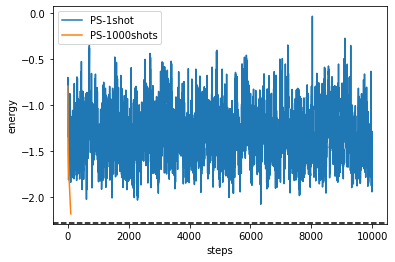

In [17]:
plt.plot(cost_history_ps_1shot, label="PS-1shot")
plt.plot(cost_history_ps, label="PS-1000shots")
plt.axhline(min(eigvals), color="black", linestyle="dashed")
plt.ylabel("energy")
plt.xlabel("steps")
plt.legend()
plt.show()

全然だめですね。確率的勾配降下法を収束させるためにはステップ幅 $\alpha$ を小さくしていかないといけないからです。そこで次は $\alpha = \alpha_0/(\text{number of steps})$ で変化させていきます。

In [18]:
n_steps = 10000
n_shots = 1
rate = 0.1
np.random.seed(1)
params = (2*np.random.random(circuit.get_parameter_count())-1)*np.pi
cost_history_ps_1shot = np.zeros(n_steps)
for i in tqdm(range(n_steps)):
    params -= sample_gradient_by_parameter_shift(params, n_shots)*rate/(i+1)
    cost_history_ps_1shot[i] = get_cost(params)

100%|██████████| 10000/10000 [03:05<00:00, 53.81it/s]


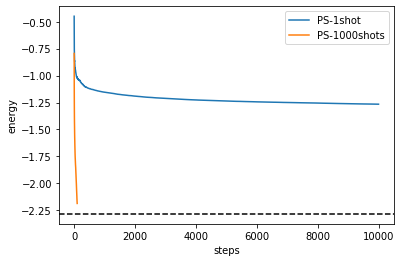

In [19]:
plt.plot(cost_history_ps_1shot, label="PS-1shot")
plt.plot(cost_history_ps, label="PS-1000shots")
plt.axhline(min(eigvals), color="black", linestyle="dashed")
plt.ylabel("energy")
plt.xlabel("steps")
plt.legend()
plt.show()

一応上よりは良くなりましたし、無限に続ければ収束しそうな雰囲気です (?)